In [100]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import spatial
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = (20,5)

import doremus_data

In [375]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record, index - 1
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

Load data.

In [2]:
training_data_folder = '/Users/pasquale/git/recommender/training_data'
emb_folder = '/Users/pasquale/git/music-embeddings'

doremus_data.init(training_data_folder, emb_folder)
vectors, uris, lbs, heads, heads_print = doremus_data.get_embeddings('expression')
pd.DataFrame(heads_print)

,0,1,2,3,4
0,casting,composer,genre,key,composition_date
1,3,3,3,3,1


In [3]:
all_training = doremus_data.all_training('expression')
for t in all_training:
    num_playlists = len(t['playlists'])
    print('%s\t\t%d' % (t['name'], num_playlists))

pp_concerts		223
itema3_concerts		414
web-radio		105
spotify_pl		65


In [4]:
_l = 5

for t in all_training:
    temp_playlists = []
    for pl in t['playlists']:
        for i in np.arange(len(pl['data']) - _l):
            temp_playlists.append(pl['data'][i:i+_l])
    t['groups'] = [{'name':str(index), 'data': pl} for index, pl in enumerate(temp_playlists)]
    print('%s\t\t%d' % (t['name'], len(temp_playlists)))

pp_concerts		1446
itema3_concerts		2678
web-radio		1409
spotify_pl		1511


Data pre-processing

In [5]:
negVector = -2. * np.ones_like(vectors[0], dtype=np.float32)

def get_embs(x):
    # uri to embedding
    v = vectors[np.argwhere(uris == x)]
    if v.size == 0:
        print(x)
        result = np.array(negVector)
    else:
        result = np.array(v[0][0])
    return result

def get_label(x):
    l =  lbs[np.argwhere(uris == x)]
    return l[0][0] if l.size > 0 else 'none'

In [6]:
np.set_printoptions(2)
def compute_playlist_stats(playlist, to_print=False):
    pl = playlist['data']
    embeddings = np.array([get_embs(xi) for xi in pl])
    emb_len = len(embeddings[0])
    
    ma_embeddings = np.ma.array(embeddings, mask=embeddings < -1.)

    # I do not want to mean dimensions with single values
    mul_values = np.where(np.sum(embeddings >= -1., axis=0) > 1, False, True)
    mul_values = np.repeat([mul_values], len(pl), axis=0)
    ma_embeddings = np.ma.array(ma_embeddings, mask=mul_values)

    _mean = ma_embeddings.mean(axis=0)
    _median = np.ma.median(ma_embeddings, axis=0)
    _min = np.ma.min(ma_embeddings, axis=0)
    _max = np.ma.max(ma_embeddings, axis=0)
    _std = np.ma.std(ma_embeddings, axis=0)
    
    if to_print:
        plt.errorbar(np.arange(len(_mean)), _mean, _std, fmt='ok',
                     ecolor='black', elinewidth=1.5, lw=3, capsize=2)
        plt.errorbar(np.arange(len(_mean)), _mean, [_mean - _min, _max - _mean],
                 fmt='.k', ecolor='gray', elinewidth=0.5, lw=1, capsize=1)

        plt.errorbar(np.arange(len(_mean)), _median, fmt='_g',  lw=1)

        plt.xticks(range(len(heads)), heads, rotation=40)
        plt.show()

    return _mean, _median, _std

Sample playlist

Base: spotify_pl
Playlist: 1023


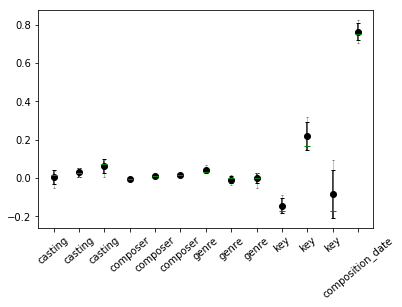

http://overture.doremus.org/expression/ca951b03-f84b-3a7a-aef0-7023af6e8b35
Symhonies
[0.03590903803706169 0.007821599952876568 0.09708871692419052
 -0.006353070493787527 0.008631796576082706 0.015063508413732052
 0.03582938387989998 -0.015889763832092285 0.02758117951452732
 -0.0902123674750328 0.3212423026561737 0.09681284427642822
 0.8038095235824585]
http://overture.doremus.org/expression/41ace8c4-a1b7-3b9d-8339-026e14ed1b54
Symphonies
[-- -- -- -0.003346540266647935 0.012496697716414928 0.012410242110490799
 0.03334466740489006 -0.001616666791960597 0.0029975688084959984
 -0.1695733219385147 0.1698441505432129 -0.1706843227148056
 0.7371428608894348]
http://overture.doremus.org/expression/b53f42ba-9ec1-3e3d-9aa2-1fbff4405093
Requiem
[-0.05006037652492523 0.05418456718325615 0.05414140969514847
 -0.003299245610833168 0.012398893013596535 0.012594932690262794
 0.0664895549416542 0.014949981123209 -0.04941561073064804
 -0.1695733219385147 0.1698441505432129 -0.1706843227148056
 0.705

In [7]:
base = all_training[3]
print('Base: ' + base['name'])
pl = base['groups'][1023]
print('Playlist: ' + pl['name'])

m, md, s = compute_playlist_stats(pl, True)

for d in pl['data']:
    print(d.replace('data', 'overture'))
    print(get_label(d)) 
    print(np.ma.array(get_embs(d), mask=get_embs(d) < -1.))

Standard Deviation among all playlists

In [8]:
population_tot = np.sum([len(pl['data']) for tr in all_training for pl in tr['groups'] ])
std = {}
population = {}
mean = {}
stdw = {} # std within
stdb = {} # std between
                      
for index, tr in enumerate(all_training):
    name = tr['name']
    std[name] = []
    population[name] = []
    mean[name] = []
    for index, pl in enumerate(tr['groups']):
        _mean, _median, _std = compute_playlist_stats(pl, False)
        pop = len(pl['data'])
        population[name].append(pop)
        mean[name].append(_mean)
        ww = (pop - 1) / (population_tot - 1)
        std[name].append((_std**2)*ww)

    stdw[name] = np.ma.sum(std[name], axis=0).filled(0)

In [9]:
weighted_means = [np.ma.mean(mean[name], axis=0)*np.sum(population[name]) for name in mean]

mtot = np.ma.sum(weighted_means, axis=0)
mtot /= population_tot

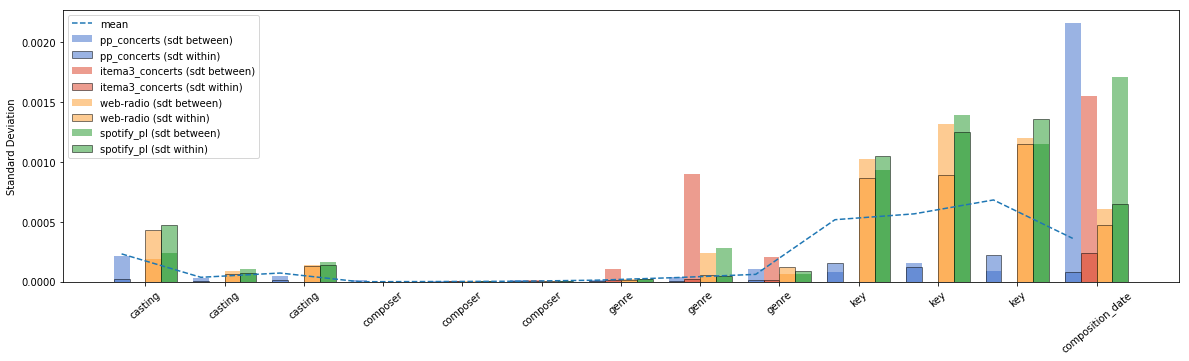

Standard Deviation: mean
[2.33e-04 3.75e-05 7.31e-05 6.52e-07 2.19e-06 4.60e-06 1.36e-05 3.53e-05
 6.20e-05 5.18e-04 5.67e-04 6.83e-04 3.62e-04]
Standard Deviation: minimum
[0.00e+00 0.00e+00 0.00e+00 2.12e-07 1.47e-06 2.89e-06 3.69e-06 8.53e-06
 1.10e-05 0.00e+00 0.00e+00 0.00e+00 8.17e-05]
Standard Deviation between: mean
[1.61e-04 5.63e-05 8.80e-05 5.31e-06 4.64e-06 1.09e-05 3.99e-05 3.65e-04
 1.12e-04 5.11e-04 7.17e-04 6.09e-04 1.51e-03]


In [10]:
fig, ax = plt.subplots(figsize=(20,5))
width = 0.2
pos = np.arange(len(vectors[0]))
colors = ['#3668C9', '#DA3B21', '#FD9827', '#1D9424']


for index, tr in enumerate(all_training):
    name = tr['name']
    
    ww = np.array([pop / (population_tot - 1) for pop in population[name]])
    mg = np.ma.power(np.ma.array(mean[name]).filled(mtot) - mtot, 2)
    stdb[name] = np.ma.sum(mg * ww.reshape(len(ww),1), axis=0)

    plt.bar([p + index * width for p in pos],
        stdb[name],
        width,
        alpha=0.5,
        color=colors[index],
        label=name + ' (sdt between)')
    
    plt.bar([p + index * width for p in pos],
        stdw[name] ,
        width,
        edgecolor='#000000',
        alpha=.5,
        color=colors[index],
        label=name + ' (sdt within)')
    

    
flat_std = [stdw[name] for name in stdw]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)

ax.plot(pos, mstd, '--', label='mean')

plt.xticks(range(len(heads)), heads, rotation=40)
ax.set_ylabel('Standard Deviation')
ax.set_xticks([p + 1.5 * width for p in pos])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')
plt.show()

print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))

flat_std_b = [stdb[name] for name in stdb]
mstd_b = np.ma.mean(flat_std_b, axis=0)
print('Standard Deviation between: mean' )
print(np.array(mstd_b))

#### Explaination

When the standard deviation _within_ (black border) is smaller then the standard deviation _between_ (no border), this means that for that dimension the values are more omogeneuos _inside_ the group than _outside_.
If this difference in omogeneity inside/outside is important, I can state that this dimension drives the playlist generation.

### Graphs property by property

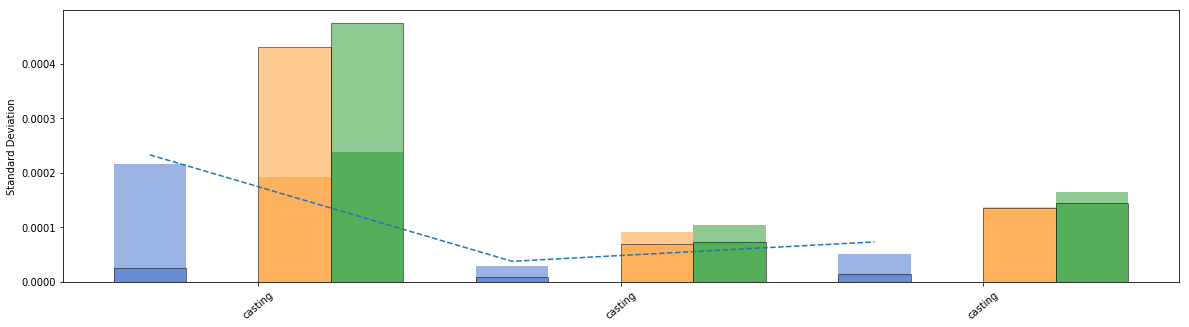

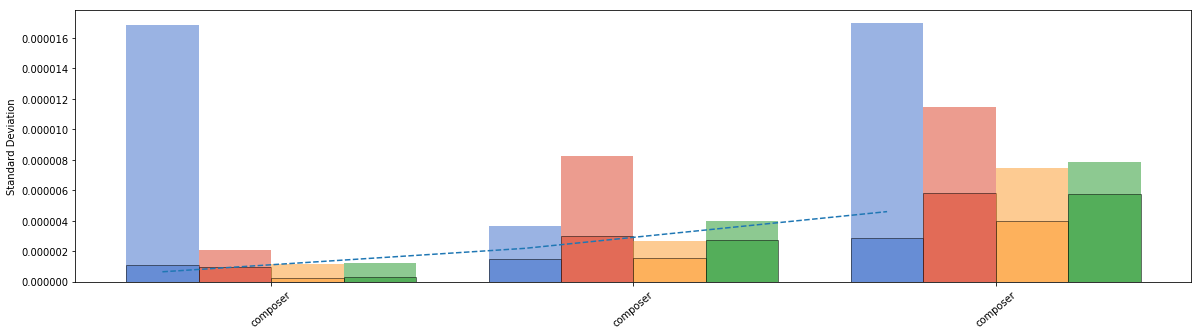

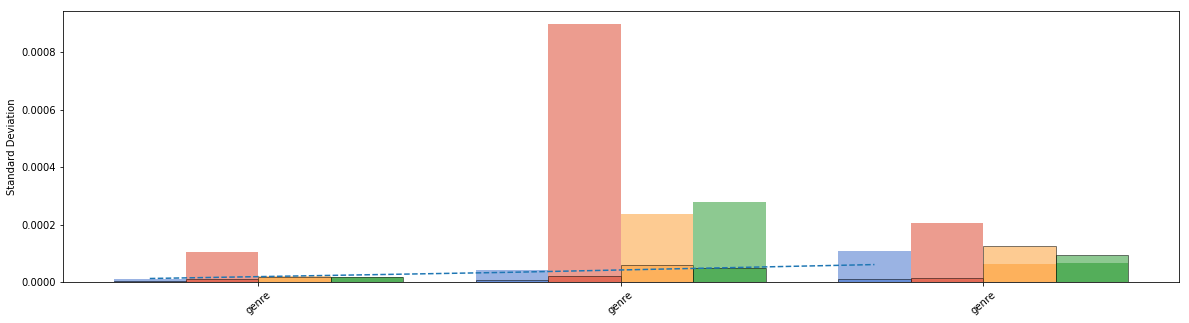

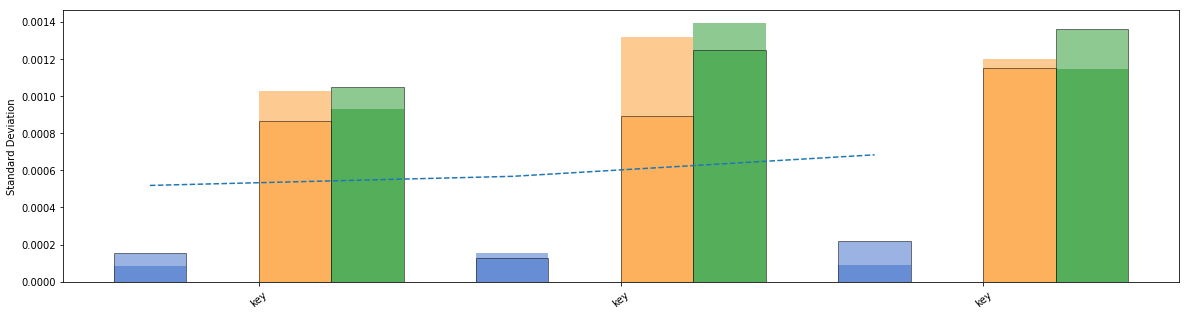

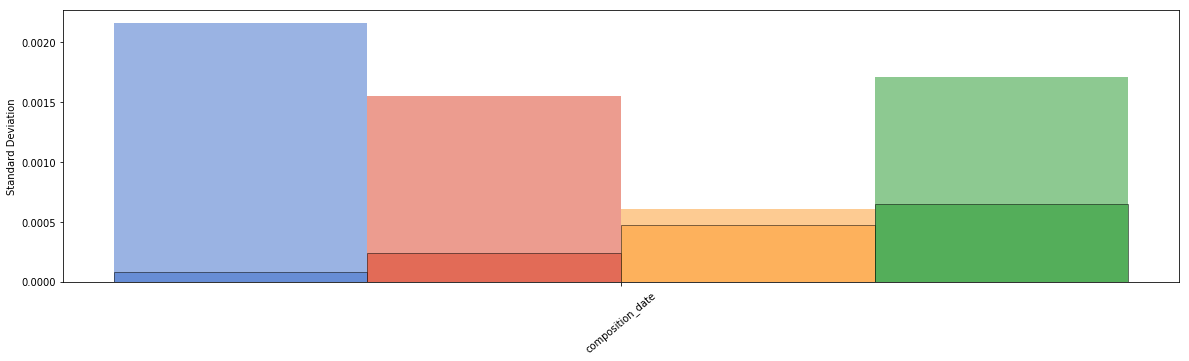

In [11]:
def display_graph(feat):
    pos = np.where(np.array(heads) == feat)[0]
    pos_slide = np.arange(len(pos))
    fig, ax = plt.subplots(figsize=(20,5))

    for index, tr in enumerate(all_training):
        name = tr['name']
        plt.bar([p + index * width for p in pos_slide],
            stdb[name][pos],
            width,
            alpha=0.5,
            color=colors[index],
            label=name + ' (sdt between)')

        plt.bar([p + index * width for p in pos_slide],
            stdw[name][pos] ,
            width,
            alpha=0.5,
            edgecolor='#000000',
            color=colors[index],
            label=name + ' (sdt within)')

    ax.plot(pos_slide, mstd[pos], '--', label='mean')

    plt.xticks(pos_slide, np.array(heads)[pos], rotation=40)
    ax.set_ylabel('Standard Deviation')
    ax.set_xticks([p + 1.5 * width for p in pos_slide])
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels, loc='upper left')
    plt.show()
    
    
for _f in heads_print[0]:
    display_graph(_f)

For concerts

In [12]:
flat_std = [s for name in ['pp_concerts','itema3_concerts'] for s in std[name]]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)

print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))
print('Standard Deviation: maximum' )
print(np.array(smax))

Standard Deviation: mean
[5.75e-08 2.07e-08 3.08e-08 6.18e-10 1.32e-09 2.55e-09 5.15e-09 9.59e-09
 8.84e-09 1.76e-06 1.45e-06 2.51e-06 1.69e-07]
Standard Deviation: minimum
[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 3.32e-08 3.55e-09 3.28e-08 0.00e+00]
Standard Deviation: maximum
[4.34e-07 2.16e-07 2.62e-07 7.64e-09 1.45e-08 1.61e-08 1.66e-07 2.10e-07
 2.68e-07 6.89e-06 5.72e-06 8.69e-06 4.12e-05]


For playlists

In [13]:
flat_std = [s for name in ['web-radio','spotify_pl'] for s in std[name]]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)


print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))
print('Standard Deviation: maximum' )
print(np.array(smax))

Standard Deviation: mean
[3.11e-07 4.85e-08 9.58e-08 1.72e-10 1.46e-09 3.33e-09 1.33e-08 3.83e-08
 7.59e-08 1.34e-06 1.50e-06 1.76e-06 3.87e-07]
Standard Deviation: minimum
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Standard Deviation: maximum
[1.58e-06 3.18e-07 5.52e-07 1.71e-09 1.02e-08 1.33e-08 1.61e-07 3.38e-07
 6.62e-07 7.71e-06 8.56e-06 8.69e-06 7.55e-06]


# Recommend

In [14]:
all_song = []
for t in all_training:
    if t['name'] in ['web-radio','spotify_pl']:
        for pl in t['playlists']:
             all_song = np.concatenate([all_song, pl['data']])
all_song = np.unique(all_song)
len(all_song)

2563

In [15]:
all_song_vec = np.array([get_embs(xi) for xi in all_song])
all_song_vec = np.ma.array(all_song_vec, mask=all_song_vec < -1.)
all_song_labels = np.array([get_label(xi) for xi in all_song])

In [16]:
def search_for_candidates(seed, cut):
    _seed = seed[seed.mask==False]
    _cut = cut[seed.mask==False]
    _pool = all_song_vec[:,seed.mask==False]
    
    seed_top = _seed + _cut
    seed_bottom = _seed - _cut
    
    candidates_pos = np.where(((_pool <= seed_top) & (_pool >= seed_bottom)).filled(), 0, 1)
    candidates_pos = np.sum(candidates_pos, axis=1)
    candidates_pos = np.where(candidates_pos == 0)
    return candidates_pos

In [17]:
# from IPython.display import display

# pl = all_training[3]['playlists'][11]
# print(pl['name'])
# pl_data = pl['data']
# print(len(pl_data))
# chosen = pl_data[3]
# print(get_label(chosen))
# print(chosen.replace('data.', 'overture.'))
# first = get_embs(chosen)
# first = np.ma.array(first, mask=first < -1.)
# print(first)
# second = get_embs(pl_data[1])
# second = np.ma.array(second, mask=second < -1.)
# print(second)
# print(cut)

# print(abs(first - second)<cut)


# candidates_pos = search_for_candidates(first, cut)

# candidates = all_song_vec[candidates_pos]
# candidates_labels = all_song_labels[candidates_pos]
# candidates_uris = all_song[candidates_pos]

# cos_sim = cosine_similarity(first.reshape(1, -1), candidates)[0]
# cos_sim_sort = np.argsort(-cos_sim)[1:]

# cos_sim = cos_sim[cos_sim_sort]
# candidates = candidates[cos_sim_sort]
# candidates_labels = candidates_labels[cos_sim_sort]
# candidates_uris = candidates_uris[cos_sim_sort]

# trues = 0
# print(candidates.shape[0])
# for c in np.arange(candidates.shape[0]):
#     _sig = '  X  ' if candidates_uris[c] in pl_data else '   '
#     print('%.3f'% cos_sim[c] + '\t' + _sig + '\t' + candidates_labels[c])
#     if candidates_uris[c] in pl_data: trues+=1
#     print('\t\t'+ candidates_uris[c].replace('data.', 'overture.'))
# #     display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

# print(trues)

In [18]:
# mstd.data

In [19]:
def computeSimilarity(seed, target, w):
    b1 = np.where(seed.mask==True)[0]
    b2 = np.where(target.mask==True)[0]
    bad_pos = np.unique(np.concatenate([b1, b2]))

    _seed = np.delete(seed, bad_pos, axis=0)
    _target = np.delete(target, bad_pos, axis=0)
    _w = np.delete(w, bad_pos, axis=0)

    if len(_seed) == 0:
        return 0

    # distance
    d = weightedL2(_seed, _target, _w)

    # how much info I am not finding
    penalty = len([x for x in b2 if x not in b1]) / len(seed)

    # score
    s = (max_distance - d) / max_distance
    return s * (1 - penalty)


def weightedL2(a, b, w=1):
#     return distance.cosine(a,b)
    # https://stackoverflow.com/a/8861999/1218213
    q = a - b
    return np.sqrt((w * q * q).sum())
#     return (w * q * q).sum()


_ones = np.ones(all_song_vec[0].shape)
max_distance = weightedL2(_ones,-_ones, _ones)

In [20]:
_vectors = all_song_vec
_uris =  all_song
_lbs = all_song_labels

def find(seed, n=4, w=None, _print=True):
    global max_distance
    global vectors
    global uris
    global lbs
    
    f_length = len(seed)
    
    _seed = seed
    
    if w is None:
        w = np.ones(len(_seed))
        w = w / w.sum()
    else:
        w = np.array(w)
#         temp = [np.ones(f_length[k]) * w[k] for k in range(len(w))]
#         w = np.array([item for sublist in temp for item in sublist])

    max_distance = weightedL2(np.ones(len(_seed)), np.ones(len(_seed)) * -1, w)

    if _print==True: print('computing scores')
    scores = np.array([[computeSimilarity(_seed, x.astype(float), w) for x in _vectors]])
    full = np.concatenate([_uris.reshape(len(_uris), 1), scores.transpose(), _lbs.reshape(len(_uris), 1)], axis=1)

    # remove the seed from the list
#     full = np.delete(full, pos, 0)

    # sort
    full_sorted = sorted(full, key=lambda _x: float(_x[1]), reverse=True)
    most_similar = full_sorted[:n]
    if _print==True: print('\n'.join('%s %s\n%s' % (f[0], f[1], f[2]) for f in most_similar))

    return [{'uri': _a[0], 'score': float(_a[1])} for _a in most_similar]



In [21]:
pl = all_training[2]['playlists'][15]
print(pl['name'])
pl_data = pl['data']
print(len(pl_data))
chosen = pl_data[3]
print(get_label(chosen))
print(chosen.replace('data.', 'overture.'))
first = get_embs(chosen)
first = np.ma.array(first, mask=first < -1.)


candidates = find(first, n=500, _print=False )
candidates_2 = find(first, n=500, _print=False, w = 1. - (np.sqrt(mstd.data)*10) )
trues = 0
for index, c in enumerate(candidates):
    _sig = '  X  ' if c['uri'] in pl_data else '   '
#     print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
    if c['uri'] in pl_data: trues+=1
#     print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
#     display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

print(trues-1)

trues = 0
for index, c in enumerate(candidates_2):
    _sig = '  X  ' if c['uri'] in pl_data else '   '
#     print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
    if c['uri'] in pl_data: trues+=1
#     print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
#     display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

print(trues-1)

# print(candidates[270:273])
# print(candidates_2[270:273])



/Users/pasquale/git/recommender/training_data/web-radio/output/list/expression/FM-401_20170306_00-02.expression.txt
10
Sérénade italienne
http://overture.doremus.org/expression/e4b161cb-a3a9-30ba-87ce-94babf775597
4
4


In [323]:
def get_std_gap(_chosen):
#     return (stdb[_chosen] - stdw[_chosen]) / ((stdw[_chosen] + stdb[_chosen]) / 2 )
    return  stdb[_chosen] / stdw[_chosen]

def display_distances(_chosen):
    better =(stdw[_chosen]<=stdb[_chosen]).tolist()
    distance = get_std_gap(_chosen)

    pd.set_option('precision', 3)
    return pd.DataFrame([better, distance.tolist(), stdw[_chosen].tolist(), stdb[_chosen].tolist()], 
                        index=['omongeneous', '% rate', 'std within', 'std between'], columns=heads)

In [324]:
display_distances('spotify_pl')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
omongeneous,False,True,True,True,True,True,False,True,False,False,True,False,True
% rate,0.5,1.45,1.14,4.15,1.47,1.37,0.999,5.5,0.728,0.886,1.12,0.843,2.65
std within,0.000475,7.24e-05,0.000144,2.9e-07,2.72e-06,5.75e-06,2.05e-05,5.09e-05,9.42e-05,0.00105,0.00125,0.00136,0.000646
std between,0.000237,0.000105,0.000164,1.21e-06,4e-06,7.87e-06,2.05e-05,0.00028,6.86e-05,0.000931,0.00139,0.00115,0.00171


In [325]:
display_distances('web-radio')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
omongeneous,False,True,True,True,True,True,True,True,False,True,True,True,True
% rate,0.444,1.32,1.01,5.41,1.73,1.88,1.16,3.91,0.495,1.19,1.47,1.04,1.26
std within,0.000432,6.88e-05,0.000135,2.12e-07,1.55e-06,3.96e-06,1.81e-05,6.05e-05,0.000127,0.000868,0.000894,0.00115,0.000478
std between,0.000192,9.09e-05,0.000137,1.15e-06,2.68e-06,7.46e-06,2.1e-05,0.000236,6.27e-05,0.00103,0.00132,0.0012,0.000604


In [326]:
display_distances('pp_concerts')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
omongeneous,True,True,True,True,True,True,True,True,True,False,True,False,True
% rate,8.67,3.29,3.82,14.9,2.49,5.88,3.26,5.07,9.85,0.536,1.23,0.42,26.5
std within,2.49e-05,8.95e-06,1.33e-05,1.13e-06,1.47e-06,2.89e-06,3.69e-06,8.53e-06,1.1e-05,0.000155,0.000127,0.000221,8.17e-05
std between,0.000216,2.94e-05,5.09e-05,1.68e-05,3.64e-06,1.7e-05,1.21e-05,4.33e-05,0.000108,8.31e-05,0.000157,9.26e-05,0.00216


In [327]:
display_distances('itema3_concerts')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
omongeneous,True,True,True,True,True,True,True,True,True,True,True,True,True
% rate,None,None,None,2.14,2.74,1.98,8.68,42.7,12.7,None,None,None,6.37
std within,0,0,0,9.76e-07,3.02e-06,5.79e-06,1.22e-05,2.11e-05,1.63e-05,0,0,0,0.000244
std between,0,0,0,2.09e-06,8.26e-06,1.14e-05,0.000106,0.0009,0.000208,0,0,0,0.00155


2 different tendences between concerts and playlists.

In **concerts** all the dimensions (where they exist) are more omogeneous. This is true in particular for the **casting** (not to be used instead for playlists), and this is reasonable.

The 1st dimension of **composer** is also one to take in account.
In Itema3 this is not visible probably because of bad interlinking of artists.

For the keys, the values are not so relevant and not stable in positiveness.

Always positive (in **bold** the largely ones):
- **composer[0]**
- composer[1,2]
- **genre[2]**
- composition_date
- key[2]
- casting[2]

Positive only in concerts:
- **casting[all]**
- **genre[all]**
- **composition_date**



## Recommendations

In [419]:
dist = [get_std_gap(_chosen) for _chosen in ['spotify_pl', 'web-radio']]
dist = np.ma.mean(dist, axis=0).filled()

threshold = 1.3
w = np.where(dist > threshold, dist, .7)
# w[-1] *= 0

pd.DataFrame([w], columns=heads)

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
0,0.7,1.385,0.7,4.783,1.601,1.626,0.7,4.706,0.7,0.7,0.7,0.7,1.958


In [420]:
def recommend_compare(playlist, pos=-1, num_candidates=[100, 200, 500], verbose=True, overture=True):
    pl_data = playlist['data']
    pl_population = len(pl_data)
    if verbose: print('%d items | %s' % (pl_population, playlist['name'].split('/')[-1]))
    
    _replcm = 'overture.' if overture else 'data.'
    
    if pos < 0: pos = random.randrange(pl_population)
    chosen = pl_data[pos]
    if verbose: 
        print('seed: %d) %s' % (pos, get_label(chosen)))
        print('\t '+ chosen.replace('data.', _replcm))
    
    first = get_embs(chosen)
    first = np.ma.array(first, mask=first < -1.)
#     print(first)

    candidates = find(first, n=np.max(num_candidates), _print=False )
    candidates_2 = find(first, n=np.max(num_candidates), _print=False, w = w )
    
    results = np.zeros((len(num_candidates), 3))
    
    for qi, q in enumerate(num_candidates):
        trues_flat = 0
        for index, c in enumerate(candidates[:q]):
            if c['uri'] == chosen: continue
        #     _sig = '  X  ' if c['uri'] in pl_data else '   '
    #         print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
            if c['uri'] in pl_data: trues_flat+=1
        # #     print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
        # #     display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))


        trues = 0
        for index, c in enumerate(candidates_2[:q]):
            if c['uri'] == chosen: continue
        #     _sig = '  X  ' if c['uri'] in pl_data else '   '
        # #     print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
            if c['uri'] in pl_data: trues+=1
        # #     print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
        # #     display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

        if verbose: print('%d | flat %d | weighted %d | diff %d' % (q, trues_flat, trues, trues-trues_flat))
        results[qi] = [trues / pl_population, trues_flat / pl_population, (trues-trues_flat) / pl_population]
    return results

In [422]:
pl = all_training[3]['playlists'][41]
recommend_compare(pl, 14)

15 items | 37i9dQZF1DX6Oqe1LC2A2s.Next Classical.expression.txt
seed: 14) Symphonies. No 8
	 http://overture.doremus.org/expression/05874d0b-9f40-3301-a69e-32cd7a9384df
100 | flat 2 | weighted 4 | diff 2
200 | flat 4 | weighted 4 | diff 0
500 | flat 6 | weighted 8 | diff 2


array([[0.27, 0.13, 0.13],
       [0.27, 0.27, 0.  ],
       [0.53, 0.4 , 0.13]])

### Playlists

In [426]:
rc = {}
quantities = [100, 200, 500]
_headers = np.array([['weighted %d' % q, 'flat %d' % q, 'diff %d' % q] for q in quantities]).flatten()

def compute_for_dataset(dataset):
    playlists = dataset['playlists'][0:5]
    current = np.zeros((len(playlists), 3*len(quantities)))
    for pl, idxp in log_progress(playlists, name=dataset['name']):
        rcomp = [recommend_compare(pl, elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        current[idxp] = np.mean(rcomp, axis=0)
    return current

In [ ]:
for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
    rc[dataset['name']] = compute_for_dataset(dataset)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))

In [418]:
# rc

In [417]:
_data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

pd.DataFrame(
    _data,
    index = [ds for ds in rc],
    columns = _headers
)

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
pp_concerts,0.019,0.017,2.247e-03,0.021,0.022,-1.637e-03,0.025,0.027,-0.001
itema3_concerts,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000,0.000,0.000
web-radio,0.057,0.052,4.964e-03,0.104,0.101,3.173e-03,0.239,0.226,0.013
spotify_pl,0.096,0.097,-9.448e-04,0.143,0.144,-6.134e-04,0.276,0.265,0.010
